### Reacher-v2 Environment

In [16]:
import gym
import time
import random

In [17]:
env = gym.make("Reacher-v2")
state = env.reset()

In [18]:
env.observation_space


Box(11,)

In [19]:
env.action_space
# [random.choice(env.action_space) for _ in range(10)]

[[-0.05, 0],
 [-0.025, 0],
 [-0.01, 0],
 [0.01, 0],
 [0.025, 0],
 [0.05, 0],
 [0, -0.05],
 [0, -0.025],
 [0, -0.01],
 [0, 0.01],
 [0, 0.025],
 [0, 0.05]]

In [5]:
for _ in range(1000):
    action = random.choice(env.action_space)
    env.step(action)
    env.render()
env.close()

Creating window glfw


### Render images

In [5]:
images = []
for _ in range(10):
    data = env.render(mode='rgb_array', width=256, height=256)
    images.append(data)
#     action = env.action_space.sample()
#     actions = [[0.1, 0], [0,0.1]]
#     action = random.choice(actions)
    action = random.choice(env.action_space)
#     print("Action: ", action)
    env.step(action)
env.close()
print(data.shape)

Creating offscreen glfw
In def step....... True
In def step....... True
In def step....... True
In def step....... True
(256, 256, 3)


In [7]:
len(images)

10

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


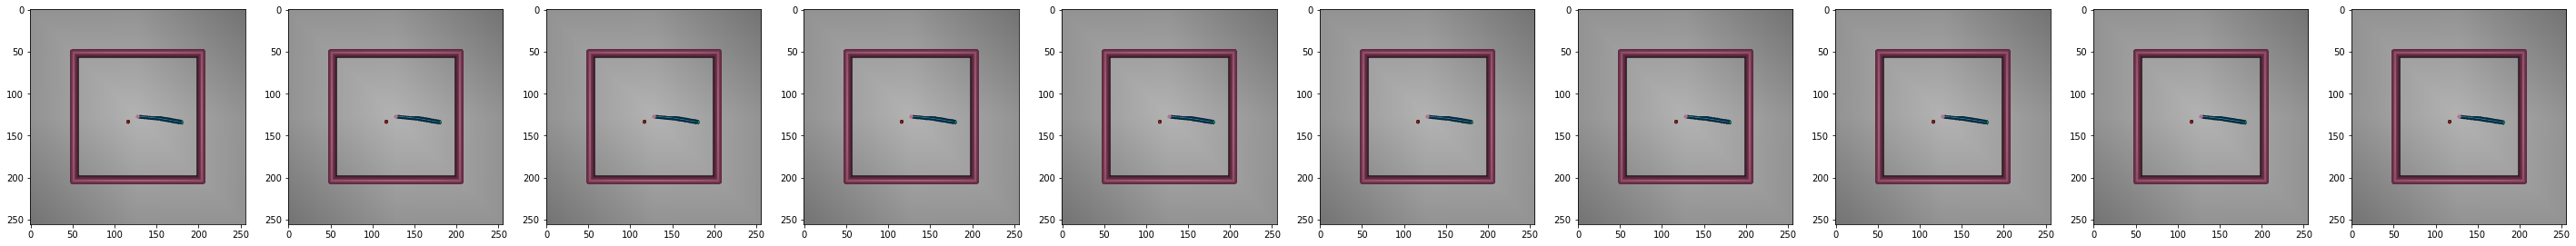

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (50,50))
for i in range(len(images)):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(images[i])
    print(images[i].shape)
plt.show()
 
# plt.imshow(data, interpolation='nearest')

# w=10
# h=10
# fig=plt.figure(figsize=(8, 8))
# columns = 5
# rows = 2
# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()

### Densely-connected NN 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 16)                192       
_________________________________________________________________
dense_58 (Dense)             (None, 12)                204       
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 16)                192       
_________________________________________________________________
dense_60 (Dense)             (None, 12)                204       
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________
Pre-trained model doesn't exist.
episode: 0   score: -2.0599691811688974  q_valu

episode: 84   score: 0.9587892950734317  q_value: [1.97612618]   memory length: 1062
episode: 85   score: 15.456184879960304  q_value: [2.19981822]   memory length: 1082
episode: 86   score: 0.9380533497688772  q_value: [2.95860964]   memory length: 1083
episode: 87   score: 67.58584399488814  q_value: [3.29024621]   memory length: 1158
episode: 88   score: -1.0893453163606002  q_value: [3.7057527]   memory length: 1159
episode: 89   score: -1.1026564416876474  q_value: [4.04201534]   memory length: 1160
episode: 90   score: -1.0544381911610328  q_value: [4.09164015]   memory length: 1161
episode: 91   score: -1.0909211803004497  q_value: [4.33943112]   memory length: 1162
episode: 92   score: -1.0328306505785694  q_value: [4.44896722]   memory length: 1163
episode: 93   score: -1.0943596304279841  q_value: [4.60710577]   memory length: 1164
episode: 94   score: 0.9601400654229213  q_value: [4.67402467]   memory length: 1165
episode: 95   score: -0.28517141824404235  q_value: [4.903684

episode: 181   score: 0.9536430844252279  q_value: [10.06657109]   memory length: 2302
episode: 182   score: 48.38641747112026  q_value: [10.09462072]   memory length: 2357
episode: 183   score: -1.0545277810696863  q_value: [10.15603626]   memory length: 2358
episode: 184   score: 0.9647085596702726  q_value: [10.23429058]   memory length: 2359
episode: 185   score: 88.92101744152758  q_value: [10.47825212]   memory length: 2456
episode: 186   score: 0.921905826842082  q_value: [9.85849471]   memory length: 2457
episode: 187   score: -1.0638489317455329  q_value: [9.86176787]   memory length: 2458
episode: 188   score: 94.30927725998664  q_value: [9.91905651]   memory length: 2558
episode: 189   score: 41.286308692351234  q_value: [10.51609798]   memory length: 2605
episode: 190   score: 0.9218973253633739  q_value: [11.28128422]   memory length: 2606
episode: 191   score: 50.52335560023956  q_value: [11.57121275]   memory length: 2661
episode: 192   score: 0.9189946530734457  q_value

episode: 277   score: -1.0494111069420697  q_value: [14.81803025]   memory length: 4880
episode: 278   score: 69.1258365048003  q_value: [15.20283033]   memory length: 4958
episode: 279   score: 0.9793800167674299  q_value: [15.17919483]   memory length: 4959
episode: 280   score: 69.60835676201003  q_value: [15.27767197]   memory length: 5037
episode: 281   score: 0.9525892994296334  q_value: [15.20738385]   memory length: 5038
episode: 282   score: -1.0541732763159162  q_value: [14.98312143]   memory length: 5039
episode: 283   score: 50.40730842615616  q_value: [14.78438066]   memory length: 5096
episode: 284   score: -1.039624273926817  q_value: [15.53941811]   memory length: 5097
episode: 285   score: 0.9221905749276657  q_value: [15.29400372]   memory length: 5098
episode: 286   score: 52.23881477552825  q_value: [15.8594673]   memory length: 5157
episode: 287   score: 0.936193795363675  q_value: [15.61976089]   memory length: 5158
episode: 288   score: 73.15180250143331  q_value

episode: 373   score: 34.941191238352175  q_value: [18.49376113]   memory length: 7105
episode: 374   score: 0.9535062347027093  q_value: [17.65543724]   memory length: 7106
episode: 375   score: 33.9357871657178  q_value: [17.96160043]   memory length: 7145
episode: 376   score: -1.0707035998788548  q_value: [17.79538338]   memory length: 7146
episode: 377   score: 0.9612729771917606  q_value: [18.13798886]   memory length: 7147
episode: 378   score: 55.141295478768185  q_value: [18.22286423]   memory length: 7209
episode: 379   score: 0.9164331454219877  q_value: [18.04009331]   memory length: 7210
episode: 380   score: 26.02048792411535  q_value: [17.40986909]   memory length: 7241
episode: 381   score: 0.9630073007000138  q_value: [18.15447795]   memory length: 7242
episode: 382   score: 26.432175614697833  q_value: [18.33807946]   memory length: 7273
episode: 383   score: 0.979686251469253  q_value: [18.28022255]   memory length: 7274
episode: 384   score: 52.70120380273815  q_val

episode: 469   score: 50.207808260252435  q_value: [17.86171757]   memory length: 9293
episode: 470   score: 0.9467078833933263  q_value: [17.97467528]   memory length: 9294
episode: 471   score: 27.6516189987497  q_value: [17.91293054]   memory length: 9327
episode: 472   score: 0.9208767028178979  q_value: [17.58891973]   memory length: 9328
episode: 473   score: 23.092373155225175  q_value: [17.34462732]   memory length: 9356
episode: 474   score: 0.9673717697558476  q_value: [17.60075797]   memory length: 9357
episode: 475   score: 20.835434612638046  q_value: [17.49618018]   memory length: 9382
episode: 476   score: 0.9345374588782911  q_value: [17.48015461]   memory length: 9383
episode: 477   score: 26.33302510046492  q_value: [17.01378594]   memory length: 9414
episode: 478   score: 0.9367498047459153  q_value: [16.99449692]   memory length: 9415
episode: 479   score: 30.83710885625841  q_value: [16.97003559]   memory length: 9451
episode: 480   score: 0.931374541510526  q_valu

episode: 564   score: 32.107982287879906  q_value: [19.40704571]   memory length: 11559
episode: 565   score: 0.9661457364245098  q_value: [19.79873246]   memory length: 11560
episode: 566   score: 96.90315122175771  q_value: [19.90055541]   memory length: 11660
episode: 567   score: 24.04655618589294  q_value: [18.4721698]   memory length: 11689
episode: 568   score: 0.904410216609597  q_value: [19.06473594]   memory length: 11690
episode: 569   score: 60.807825662165534  q_value: [18.851362]   memory length: 11759
episode: 570   score: 0.9312757750726874  q_value: [18.97238627]   memory length: 11760
episode: 571   score: 47.805934492319835  q_value: [18.78861907]   memory length: 11815
episode: 572   score: 0.9496411496261203  q_value: [19.64551695]   memory length: 11816
episode: 573   score: 39.44933100269428  q_value: [19.42413845]   memory length: 11862
episode: 574   score: 0.9292769079618941  q_value: [18.53748499]   memory length: 11863
episode: 575   score: 31.06470068844795

episode: 658   score: 52.569120621784926  q_value: [20.13697188]   memory length: 13444
episode: 659   score: 0.973104527959832  q_value: [19.85589096]   memory length: 13445
episode: 660   score: 60.65984416280701  q_value: [18.96251461]   memory length: 13513
episode: 661   score: 0.9312160958680782  q_value: [19.26887817]   memory length: 13514
episode: 662   score: 19.386301021340753  q_value: [19.63084827]   memory length: 13538
episode: 663   score: 0.9642659020847805  q_value: [19.72031833]   memory length: 13539
episode: 664   score: 41.133318043676795  q_value: [18.97257326]   memory length: 13586
episode: 665   score: 0.9263322082087142  q_value: [17.57987736]   memory length: 13587
episode: 666   score: 52.93784155701338  q_value: [17.78573921]   memory length: 13646
episode: 667   score: -1.0908123506789518  q_value: [18.03982572]   memory length: 13647
episode: 668   score: 0.9385949902737734  q_value: [17.93009211]   memory length: 13648
episode: 669   score: 14.737778402

episode: 752   score: -1.1054570880709764  q_value: [18.55886066]   memory length: 15471
episode: 753   score: -1.0357576165558  q_value: [19.26865546]   memory length: 15472
episode: 754   score: 0.9517399291483599  q_value: [18.98957613]   memory length: 15473
episode: 755   score: 17.732713413807065  q_value: [18.84507052]   memory length: 15495
episode: 756   score: 0.9541272956063948  q_value: [19.11240394]   memory length: 15496
episode: 757   score: 57.28592491418865  q_value: [18.54501683]   memory length: 15559
episode: 758   score: 0.9227471541472755  q_value: [19.44603447]   memory length: 15560
episode: 759   score: 33.4354489083165  q_value: [19.67918928]   memory length: 15599
episode: 760   score: -1.071825884654914  q_value: [20.6684912]   memory length: 15600
episode: 761   score: 0.9436291799426476  q_value: [20.02009381]   memory length: 15601
episode: 762   score: 17.523176030867226  q_value: [19.87302369]   memory length: 15623
episode: 763   score: 0.9375026997015

episode: 847   score: 41.3350992961663  q_value: [17.21926457]   memory length: 17476
episode: 848   score: 0.9574403664597366  q_value: [17.96809592]   memory length: 17477
episode: 849   score: 45.75351761024992  q_value: [17.91304409]   memory length: 17528
episode: 850   score: 0.9240580089560005  q_value: [18.88772451]   memory length: 17529
episode: 851   score: 44.30986809148591  q_value: [18.97034796]   memory length: 17581
episode: 852   score: 0.9639594035739159  q_value: [19.48136494]   memory length: 17582
episode: 853   score: 23.4845742945614  q_value: [19.55204906]   memory length: 17610
episode: 854   score: -1.0524985716367927  q_value: [19.23532898]   memory length: 17611
episode: 855   score: 0.973403072972655  q_value: [19.78145076]   memory length: 17612
episode: 856   score: 47.43285729939371  q_value: [19.78240959]   memory length: 17665
episode: 857   score: 0.9461149596971344  q_value: [18.97644046]   memory length: 17666
episode: 858   score: 39.07001950445431

episode: 942   score: 33.34419319327997  q_value: [17.44806892]   memory length: 19641
episode: 943   score: 0.9330397176364952  q_value: [16.86035521]   memory length: 19642
episode: 944   score: 51.53203835933485  q_value: [16.92909886]   memory length: 19699
episode: 945   score: -1.0395411391110378  q_value: [16.0579145]   memory length: 19700
episode: 946   score: 0.9221214447712499  q_value: [16.41079052]   memory length: 19701
episode: 947   score: 36.675085523656215  q_value: [16.27248776]   memory length: 19743
episode: 948   score: 0.9702980985005093  q_value: [16.69961332]   memory length: 19744
episode: 949   score: 18.735861507790343  q_value: [16.02096169]   memory length: 19767
episode: 950   score: 0.9542116677455343  q_value: [16.07205145]   memory length: 19768
episode: 951   score: 46.17067425837403  q_value: [15.29191654]   memory length: 19821
episode: 952   score: -1.0996521564358333  q_value: [15.0500948]   memory length: 19822
episode: 953   score: -1.0487638365

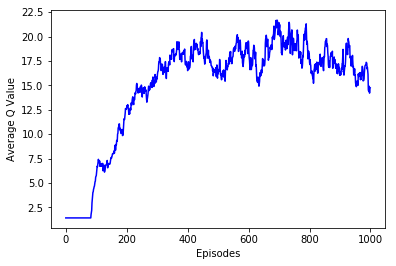

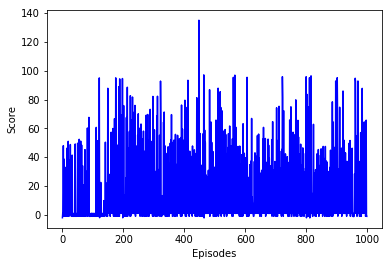

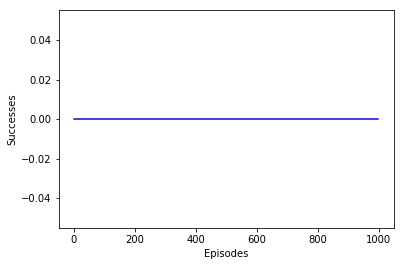

In [15]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, load_model
import os
from IPython.core.debugger import set_trace

EPISODES = 1000#Maximum number of episodes
random.seed(1)  # fix the random seed
#DQN Agent for the reacher-v2
#Q function approximation with NN, experience replay, and target network
class DQNAgent:
    #Constructor for the agent (invoked when DQN is first called in main)
    def __init__(self, state_size, action_space):
        self.check_solve = False
        self.render = False  # visualize the training process 
        self.action_space = action_space
        #Get size of state and action
        self.state_size = state_size
        self.action_size = len(action_space)
        

################################################################################
################################################################################
        #Set hyper parameters for the DQN. Do not adjust those labeled as Fixed.
        self.discount_factor = 0.95
        self.learning_rate = 0.01  # 0.005
        self.epsilon = 0.02 #Fixed
        self.batch_size = 32 #Fixed
        self.memory_size = 500000  # 1000
        self.train_start = 1000 #Fixed
        self.target_update_frequency = 1
################################################################################
################################################################################

        #Number of test states for Q value plots
        self.test_state_no =10000 # 10000

        #Create memory buffer using deque
        self.memory = deque(maxlen=self.memory_size)

        #Create main network and target network (using build_model defined below)
        self.model = self.build_model()
        self.target_model = self.build_model()

        #Initialize target network
        self.update_target_model()

    #Approximate Q function using Neural Network
    #State is the input and the Q Values are the output.
###############################################################################
###############################################################################
        #Edit the Neural Network model here
        #Tip: Consult https://keras.io/getting-started/sequential-model-guide/
    def build_model(self):
        model = Sequential()
        model.add(Dense(16, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        opt = RMSprop(lr=self.learning_rate, decay=1e-6)
        model.compile(loss='mse', optimizer=opt)
#         model.compile(loss='mse', optimizer=(lr=self.learning_rate))
        
       
        #
        # self.model = Sequential()
        # self.model.add(Dense(16, input_shape=(observation_space,), activation="relu"))
        # self.model.add(Dense(16, activation="relu"))
        # self.model.add(Dense(self.action_space, activation="linear"))
        # self.model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
###############################################################################
###############################################################################
    
    #After some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    #Get action from model using epsilon-greedy policy
    def get_action(self, state):
###############################################################################
###############################################################################
        #Insert your e-greedy policy code here
        #Tip 1: Use the random package to generate a random action.
        #Tip 2: Use keras.model.predict() to compute Q-values from the state.
        if np.random.rand() <= self.epsilon:
            ##############################################################
            # try out the self-designed method
            # First train:
#             action_range = [x for x in range(self.action_size)]
#             access = np.array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])
#             action = np.random.choice(action_range, p=access/sum(access))
            # Second train:
#             q_value = self.model.predict(state)
#             ind =  np.argmax(q_value[0])
#             action = random.choice([ind - 1, ind, ind + 1])
#             if action < 0:
#                 action = 0
#             if action > self.action_size - 1:
#                 action = self.action_size - 1
            ###############################################################
            action =  random.randrange(self.action_size)
#             print("action:", action)
        else:
            q_value = self.model.predict(state)
            action =  np.argmax(q_value[0])
#             print("q_value: ", q_value)
#             print("action: ", action)
        # action = random.randrange(self.action_size)
#         print("Action: ", action)
        return action
###############################################################################
###############################################################################
    #Save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) #Add sample to the end of the list

    #Sample <s,a,r,s'> from replay memory
    def train_model(self):
        if len(self.memory) < self.train_start: #Do not train if not enough memory
            return
        batch_size = min(self.batch_size, len(self.memory)) #Train on at most as many samples as you have in memory
        mini_batch = random.sample(self.memory, batch_size) #Uniformly sample the memory buffer
        #Preallocate network and target network input matrices.
        update_input = np.zeros((batch_size, self.state_size)) #batch_size by state_size two-dimensional array (not matrix!)
        update_target = np.zeros((batch_size, self.state_size)) #Same as above, but used for the target network
        action, reward, done = [], [], [] #Empty arrays that will grow dynamically

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]#Allocate s(i) to the network input array from iteration i in the batch
            action.append(mini_batch[i][1]) #Store a(i)
            reward.append(mini_batch[i][2]) #Store r(i)
            update_target[i] = mini_batch[i][3] #Allocate s'(i) for the target network array from iteration i in the batch
            done.append(mini_batch[i][4])  #Store done(i)

        target = self.model.predict(update_input) #Generate target values for training the inner loop network using the network model
        target_val = self.target_model.predict(update_target) #Generate the target values for training the outer loop target network
        #Q Learning: get maximum Q value at s' from target network
###############################################################################
###############################################################################
        #Insert your Q-learning code here
        #Tip 1: Observe that the Q-values are stored in the variable target
        #Tip 2: What is the Q-value of the action taken at the last state of the episode?
        for i in range(self.batch_size): #For every batch
            # target[i][action[i]] = random.randint(0,1)
            ############################################################### edited by andy
#             action2ind = {(-0.0001, 0):0,(0.0001, 0):1,(0 , -0.0001):2,(0, 0.0001):3}
#             action2ind = {(-0.0001, 0):0, (-0.01, 0):1,(0.0001, 0):2, (0.01, 0):3,(0 , -0.0001):4, (0, -0.01):5,(0, 0.0001):6, (0, 0.01):7}
            
#             action_tuple = tuple(action[i])
#             action_ind = action2ind[action_tuple]
            action_ind = self.action_space.index(action[i])
            if done[i]:
                target[i][action_ind]= reward[i]
            else:
                target[i][action_ind] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))
            #################################################################
#             if done[i]:
#                 target[i][action[i]]= reward[i]
#             else:
#                 target[i][action[i]] = reward[i] + self.discount_factor * (
#                     np.amax(target_val[i]))
###############################################################################
###############################################################################

        #Train the inner loop network
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)
        return
    
    
    def save_model(self, path_to_model, path_to_target):
            self.model.save(path_to_model)
            self.target_model.save(path_to_target)
            return
        
    def restore_model(self, path_to_model, path_to_target):
            self.model = load_model(path_to_model)
            self.target_model = load_model(path_to_target)
            return
        
    #Plots the score per episode as well as the maximum q value per episode, averaged over precollected states.
    def plot_data(self, episodes, scores, max_q_mean, success_log):
        pylab.figure(0)
        pylab.plot(episodes, max_q_mean, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Average Q Value")
        pylab.savefig("qvalues_rms.png")

        pylab.figure(1)
        pylab.plot(episodes, scores, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Score")
        pylab.savefig("scores_rms.png")
        
        
        pylab.figure(2)
        pylab.plot(episodes, success_log, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Successes")
        pylab.savefig("successes_rms.png")
if __name__ == "__main__":
    
    env = gym.make('Reacher-v2') #Generate Reacher-v2 environment object from the gym library
    #Get state and action sizes from the environment
    state_size = env.observation_space.shape[0]
    action_size = len(env.action_space)
#     action_size = env.action_space.n
    #Create agent, see the DQNAgent __init__ method for details
    agent = DQNAgent(state_size, env.action_space)
    
    #load the pre-trained model
    path_to_model = 'model_rms.h5'
    path_to_target = 'target_model_rms.h5'
    if os.path.isfile(path_to_model) and os.path.isfile(path_to_target):
        print("Loading the pre-trained model......")
        agent.restore_model(path_to_model, path_to_target)
    else:
        print("Pre-trained model doesn't exist.")
    

#     #Collect test states for plotting Q values using uniform random policy
#     test_states = np.zeros((agent.test_state_no, state_size))
#     max_q = np.zeros((EPISODES, agent.test_state_no))
#     max_q_mean = np.zeros((EPISODES,1))
#     done = True
#     for i in range(agent.test_state_no):
#         if done:
#             done = False
#             state = env.reset()
#             state = np.reshape(state, [1, state_size])
#             test_states[i] = state
#         else:
#             #############################
# #             action = random.randrange(action_size)

#             action_idx = random.randrange(action_size)
#             action = env.action_space[action_idx]
#             ###################################
# #             if done:
# #                 print("Before Done: ", done)
#             next_state, reward, done, info= env.step(action)
# #             if done:
# #                 print("Done: ", done)
# #                 print("Info: ", info)
#             next_state = np.reshape(next_state, [1, state_size])
#             test_states[i] = state
#             state = next_state

    scores, episodes = [], [] #Create dynamically growing score and episode counters
    success_log = []
    success_count = 0
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset() #Initialize/reset the environment
        state = np.reshape(state, [1, state_size]) #Reshape state so that to a 1 by state_size two-dimensional array ie. [x_1,x_2] to [[x_1,x_2]]
        #Compute Q values for plotting
        tmp = agent.model.predict(test_states)  # tmp.shape = num of test states * num of actions
        max_q[e][:] = np.max(tmp, axis=1)
        max_q_mean[e] = np.mean(max_q[e][:])
#         print("e: ", e)
#         print("tmp: ", tmp.shape)
#         print("test_states: ", test_states.shape)
        
        count = 0 
        while not done:
            
            if agent.render:
                env.render() #Show cartpole animation

            #Get action for the current state and go one step in environment
            ###################################
#             action = agent.get_action(state)
            action_idx = agent.get_action(state)
            action = env.action_space[action_idx]
            ###################################
            next_state, reward, done, success= env.step(action)
            
            next_state = np.reshape(next_state, [1, state_size]) #Reshape next_state similarly to state

            #Save sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            #Training step
            agent.train_model()
            score += reward #Store episodic reward
            state = next_state #Propagate state

            if done:
                #At the end of very episode, update the target network
                if e % agent.target_update_frequency == 0:
                    agent.update_target_model()
                #Plot the play time for every episode
                scores.append(score)
                episodes.append(e)
                if success:
                    print("Success!")
                    success_count += 1
                success_log.append(success_count)
                
                print("episode:", e, "  score:", score," q_value:", max_q_mean[e],"  memory length:",
                      len(agent.memory))

                # if the mean of scores of last 100 episodes is bigger than 195
                # stop training
                if agent.check_solve:
                    if np.mean(scores[-min(100, len(scores)):]) >= 100:
                        print("solved after", e-100, "episodes")
                        agent.plot_data(episodes,scores,max_q_mean[:e+1])
                        sys.exit()
    agent.plot_data(episodes,scores,max_q_mean, success_log)
    # Save the model
    agent.save_model(path_to_model, path_to_target)
    env.close()


In [ ]:
# test the model
import gym
env = gym.make("Reacher-v2")
agent = DQNAgent(state_size, env.action_space)

path_to_model = 'model_adam.h5'
path_to_target = 'target_model_adam.h5'
if os.path.isfile(path_to_model) and os.path.isfile(path_to_target):
    print("Loading the pre-trained model......")
    agent.restore_model(path_to_model, path_to_target)
else:
    print("Pre-trained model doesn't exist.")

n_of_steps = 100
state = env.reset()
state = np.reshape(state, [1, state_size])
for i in range(n_of_steps):
    action_idx = agent.get_action(state)
    action = env.action_space[action_idx]
    env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    env.render()
env.close()
